## Loading

In [2]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import helper 
from collections import defaultdict
import warnings
import mplfinance as mpf

current_path = os.getcwd()

SEED = 2023


In [27]:

STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", 'US10YT', '^TNX']
start_date = "2010-01-01"
end_date = "2023-01-01"
stock_data = {}
MAs = [5, 10, 20, 50, 200]

for stock in STOCKS: 
    try:
        data_path = current_path + "\data" f"\{stock}_{start_date}_{end_date}.csv"
        data = pd.read_csv(data_path)
        data['Date'] = pd.to_datetime(data['Date'])
        if stock != "^TNX":
            data = helper.compute_rsi_class(data)  # Assuming you have this function in helper
            data = helper.compute_volume_class(data)  # Add volume analysis
            data = helper.calculate_mas(data, MAs, column_name="Close")
        stock_data[stock] = data
        print(f"Data fetched for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {str(e)}")

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for US10YT
Data fetched for ^TNX


In [91]:
def determine_trend(df, short_window=50, long_window=200, threshold=0.01):
    """
    Determine the trend based on moving averages.
    
    Parameters:
    - df: DataFrame with the stock data
    - short_window: Window for the short-term SMA
    - long_window: Window for the long-term SMA
    - threshold: Percentage difference between SMAs to consider as 'No trend'
    
    Returns:
    - trend: List with 'Uptrend', 'Downtrend' or 'No trend' for each row in df
    """
    # Calculate short and long moving averages
    df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

    # Calculate the trend
    conditions = [
        (df['Short_MA'] > df['Long_MA'] * (1 + threshold)), # Uptrend condition
        (df['Short_MA'] < df['Long_MA'] * (1 - threshold))  # Downtrend condition
    ]
    choices = ['Uptrend', 'Downtrend']
    
    df['Trend'] = np.select(conditions, choices, default='No trend')
    
    return df['Trend'].tolist()

In [90]:
stock_apple = stock_data['AAPL'].copy()
stock_apple['Trend'] = determine_trend(stock_apple)
stock_apple['Date'] = pd.to_datetime(stock_apple['Date'])
stock_apple.set_index('Date', inplace=True)

c:\Users\Howard\AppData\Local\Programs\Python\Python39\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


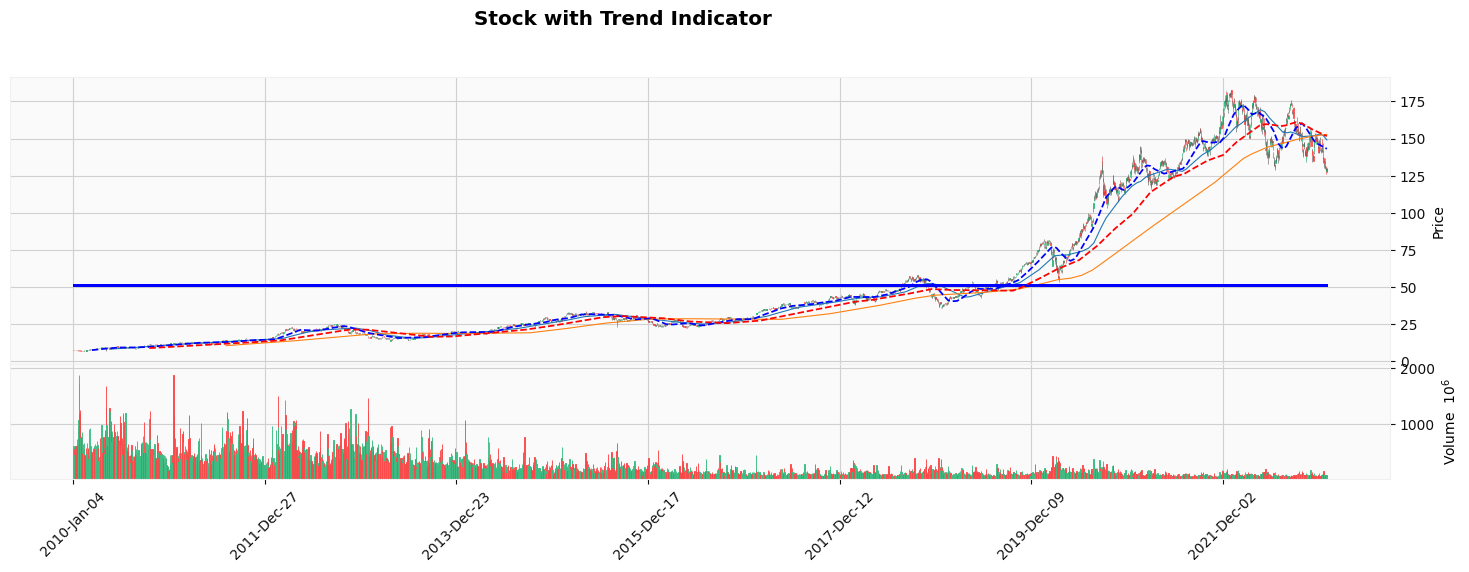

In [98]:
def plot_stock_with_trend(df):
    apdict = [mpf.make_addplot(df['Short_MA'], color='blue', linestyle='--'),
              mpf.make_addplot(df['Long_MA'], color='red', linestyle='--')]
    
    mpf.plot(df, type='candle', style='yahoo', volume=True, title='Stock with Trend Indicator',
             ylabel='Price', figratio=(400, 120), mav=(100, 400), addplot=apdict, 
             hlines=dict(hlines=[df['Close'].mean()], colors=['blue'], linewidths=[2]))

plot_stock_with_trend(stock_apple)


In [83]:
# Calculate the weekly return
stock_apple['Weekly_Return'] = stock_apple['Close'].resample('W').ffill().pct_change()


# Display statistics
stats = stock_apple['Weekly_Return'].describe()
stats

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Weekly_Return, dtype: float64

In [84]:
stock_apple['Weekly_Return']

Date
2010-01-04   NaN
2010-01-05   NaN
2010-01-06   NaN
2010-01-07   NaN
2010-01-08   NaN
              ..
2022-12-23   NaN
2022-12-27   NaN
2022-12-28   NaN
2022-12-29   NaN
2022-12-30   NaN
Name: Weekly_Return, Length: 3272, dtype: float64